# Quantum teleportation 

In this notebook we will test quantum teleportation. In the setup there are two parties, Alice and Bob, who share an entangled state, let us say $|\Phi^+\rangle$ at the beginning. Then Bob travels with his part of the state to the GFFA (galaxy far, far away). After he arrives, Alice decides to send him a quantum state $|\mu\rangle$ (in our case randomly chosen state). She performs a measurement on her side and sends the outcomes she gets (2 bits of information) to Bob. Bob, based on this information then recreates the state on his side.

Important message is that after Alice decides to send the message to Bob, the only information transferred are the two bits. Otherwise there is only the shared entangled state. Notice, how no information about the state is sent between Alice and Bob! This is one of the most important messages in this course.

## Initial settings

In [5]:
import qiskit
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from math import sin, cos, pi, sqrt
from random import random

We will standardly for the teleportation need a quantum register with 3 qubits: first is reserved for the unknown state and the other two are for the shared entangled state between Alice and Bob, with Alice's qubit being the second one and Bob's the third one.

In [6]:
qreg = qiskit.QuantumRegister(3)

# We will use three separate classical registers (bits)
# for the two bits of information Alice sends to Bob
# and the third for potential measurement of Bob
cregx = qiskit.ClassicalRegister(1, name="condX")
cregz = qiskit.ClassicalRegister(1, name="condZ")
cregbob = qiskit.ClassicalRegister(1, name="bob")

We will use both QASM simulator when we will try different random states and state vector simulator for direct comparison of sent and received state.

In [7]:
qasm = qiskit.Aer.get_backend("qasm_simulator")
statevector = qiskit.Aer.get_backend("statevector_simulator")

## Bits and pieces of circuits we will use 

In the following part we will prepare small circuit snippets that will be used to perform a specific task of the teleportation process.

### Random state preparator

We want to prepare a function that will prepare a circuit snippet that prepares a random state on the first qubit. We shall use $U_3$ unitary with randomly chosen angles $\theta$, $\phi$ and $\lambda$. As we intend to test the correctness of the teleportation, the function will return the angles as well.

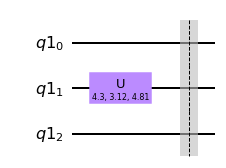

In [21]:
def random_state(qreg, a = 0):
    # Choose the angles randomly
    theta = 2*pi*random()
    phi = 2*pi*random()
    lam = 2*pi*random()
    
    # Composing the circuit
    circuit = qiskit.QuantumCircuit(qreg)
    circuit.u(theta, phi, lam, a)
    circuit.barrier()
    
    return circuit, (theta, phi, lam)

random_state(qreg, 1)[0].draw(output="mpl")

### Preparation of $|\Phi^+\rangle$ state 

We have done this in the previous notebooks. Here we will just recreate the function. Optional parameters `a` and `b` determine qubits between which the entanglement is created. Initial values are `a=0` and `b=1`.

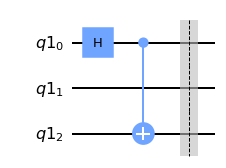

In [9]:
def phi_plus(qreg, a=0, b=1):
    circuit = qiskit.QuantumCircuit(qreg)
    circuit.h(a)
    circuit.cx(qreg[a], qreg[b])
    circuit.barrier()
    
    return circuit

phi_plus(qreg, 0, 2).draw(output="mpl")

### Bell measurement 

To perform measurement (on qubits `a` and `b`) we need to change the basis to the *z*-basis. To do this we will do the opposite as was done in Bell states creation - we will undo the entanglement from the states. We utilze the scheme, where the Bell states are created from standard basis by one Hadamard application followed by CNOT. To undo this, we just apply these reversely (normally reversely apply conjugate transposed gates). That is, we first apply CNOT between 1st and 2nd qubits and then apply $H$ on the first qubit. Afterwards the measurement in the standard basis tells us which Bell state we measured:

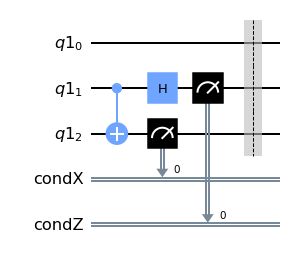

In [10]:
def bell_measure(qreg, cregx, cregz, a=0, b=1):
    circuit = qiskit.QuantumCircuit(qreg, cregx, cregz)
    
    # Operations on the two qubits
    circuit.cx(a, b)
    circuit.h(a)
    
    # Measurement
    circuit.measure(a, cregz)
    circuit.measure(b, cregx)
    
    circuit.barrier()
    
    return circuit

bell_measure(qreg, cregx, cregz, 1, 2).draw(output="mpl")

### Bob's measurement

While Bob just recieves the state and "corrects" it based on the information sent by Alice, we want to compare this state to the original one that Alice had before. We will therefore "send" also the information about created state and undo the $U_3$ gate applied during the creation of $|\mu\rangle$. If the trasferred state is the same as Alice was sending, unding the $U_3$ has to yield state $|0\rangle$.

In below we just prepare the measurement Bob will perform on his qubit.

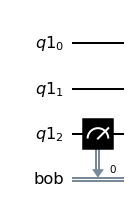

In [11]:
M = qiskit.QuantumCircuit(qreg, cregbob)
M.measure(2, 0)

M.draw(output="mpl")

### Teleportation circuit

Fianlly we have all the necessary building blocks for the creation of the teleportation circuit. Now the algorithm is as follows:
1. Create entangled state $|\Phi^+\rangle$ between Alice and Bob. (After this step Alice and Bob can get far away)
2. Prepare a random state on the side of Alice.
3. Let Alice perform Bell measurement on her two qubits and send this information to Bob.
4. Bob, conditioned on the outcome of Alice's measurement changes makes appropriate changes to his state:
   - If Alice sends `1` in `cregx` register, Bob applies $\sigma_x$ gate,
   - If Alice sends `1` in `cregz` register, Bob applies $\sigma_z$ gate.

The following circuit has these four steps separated by barriers.

*Note (remember the Qiskit speciality): When alice is sending classical bits `c[0]` and `c[1]`, she is sending a register which has a reversed order. That is `c[0]` is the right bit, while `c[1]` is the left bit. This is employed in order to have the least significant bit be `c[0]`.*

**Task 8.2:** Fill in the missing parts to create the teleportation circuit.

In [12]:
def teleport_state(state, qreg, cregx, cregz, cregbob):
    teleport = qiskit.QuantumCircuit(qreg, cregx, cregz, cregbob)
    
    """
    Prepare a circuit that would perform teleportation
    of a random state.
    
    You can use conditional state change:
    teleport.y(2).c_if(creg, 0)
    The second argument in c_if defines the value 
    of the whole classical register on which
    the application of y(2) is conditioned.
    """
    
    # Step 1: Creating enatnglement
    teleport = teleport.compose(phi_plus(qreg, 1, 2))
    
    # Step 2: Preparation of the telported state
    # (random state will be passed in the argument of the function)
    teleport = teleport.compose(state)
    
    # Step 3: Bell measurement
    teleport = teleport.compose(bell_measure(qreg, cregx, cregz, 0, 1))
    
    # Step 4: Correcting state on Bob;s side
    teleport.x(2).c_if(cregx, 1)
    teleport.z(2).c_if(cregz, 1)
    
    return teleport

Let's draw the full teleportation circuit with some random state for Alice to send.

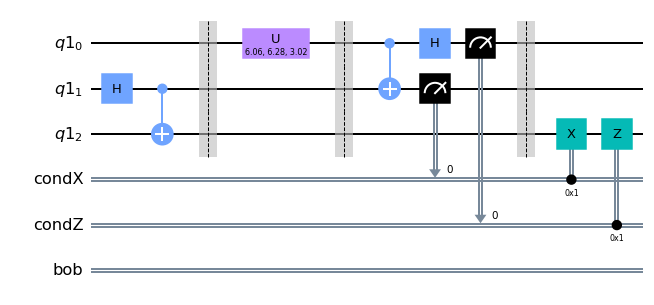

In [13]:
teleport_state(random_state(qreg)[0], qreg, cregx, cregz, cregbob).draw(output="mpl")

## Checking the teleportation success

Now we shall check whether the teleportation circuit really does what it promises. We will perform several experiments. In each we shall choose random state, let's call him *Kirk*, to be teleported. In the end we let Bob inverse the gate that was used for preparation of this state and measure. The statistics from these measurements are written into `out` dictionary.

**Task 8.3:** Fill in the missing part that will allow you to determine whether Bob has the *Kirk* state that Alice was sending to him.

In [22]:
runs = 1024
out = {}

for i in range(runs):
    # Preparation of random state named Kirk 
    kirk, (theta, phi, lam) = random_state(qreg)
    
    # Preparing the teleportation circuit called Scotty
    scotty = teleport_state(kirk, qreg, cregx, cregz, cregbob)
    
    # Bob undoes the state creation and applies measurement
    """
    Fill in here what should be done in order to test
    the function of teleportation circuit properly.
    """
    scotty.u(-theta, -lam, -phi, 2)
    scotty = scotty.compose(M, clbits=[2])
    
    # One shot experiment
    job = qiskit.execute(scotty, qasm, shots=1)
    output = tuple(list(job.result().get_counts().keys())[0].split())
    
    # Writing out the result
    out[output] = out.get(output, 0) + 1

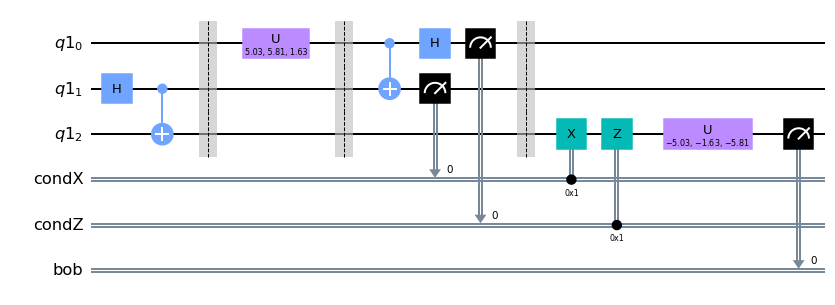

In [23]:
scotty.draw(output="mpl")

Note that now we have three separate classical (single bit) registers and the output will thuis have a different form:

In [24]:
print(out)

{('0', '1', '1'): 249, ('0', '0', '1'): 263, ('0', '0', '0'): 225, ('0', '1', '0'): 287}


Since we reverse the initialization of state $|\mu\rangle$ at the end, if the teleportation circuit works properly, Bob should always measure `0`.

In [25]:
bob_out = {"0":sum(out[key] for key in out.keys() if key[0] == "0"),
       "1":sum(out[key] for key in out.keys() if key[0] == "1")}
print(bob_out)

{'0': 1024, '1': 0}


If Bob always measures `0`, then we can disregard his output and look only at Alice's outputs.

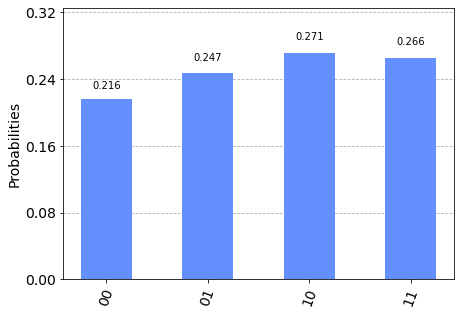

In [18]:
alice_out = {"".join(key[1:]): item for key, item in out.items()}
plot_histogram(alice_out)

What we should see is that all four possibilities of bit combinations are roughly equally likely to be measured by Alice.

## On the importance of information from Alice

In the teleportation protocol it is crutial that Alice sends the two bits she measured to Bob. We know that these two bits are random and so it might be assumed that the information about state $|\mu\rangle$ is at Bob's side. But that would be wrong to assume. It turns out that Bob's state indeed contains the information about the sent state, but he is unable to recover it without the bits from Alice.

To show that, we can consider an uncomplete teleportation protocol in which Alice does not send the bits to Bob. We can show this using density matrices (and state vectors). Consider that Alice and Bob repeat the teleportation of some chosen state *Kirk* several number of times (`runs`). Without the bits from Alice, the state that Bob observes is an average state that is arriving to him. We shall check that this *average state* does not contain infromation about state $|\mu\rangle$.

**Task 8.4:** Complete the function that prepares `teleport` circuit which simulates teleportation without Alice sending her bits to Bob.

In [19]:
def no_comm_teleport_state(state, qreg, cregx, cregz):
    teleport = qiskit.QuantumCircuit(qreg, cregx, cregz)
    
    """
    Prepare a circuit that would perform teleportation
    of a random state without Alice sending her bits.
    """
    
    # Step 1: Creating enatnglement
    teleport = teleport.compose(phi_plus(qreg, 1, 2))
    
    # Step 2: Preparation of the telported state
    # (random state will be passed in the argument of the function)
    teleport = teleport.compose(state)
    
    # Step 3: Bell measurement
    teleport = teleport.compose(bell_measure(qreg, cregx, cregz, 0, 1))
    
    # Step 4: Correcting state on Bob;s side
#     teleport.x(2).c_if(cregx, 1)
#     teleport.z(2).c_if(cregz, 1)
    
    return teleport

Using this function we can now look at two things. First we can look at the average state-vector that is sent to Bob. The less information it contains the shorter the state-vector should be.

/home/awesome/anaconda3/envs/kvant_test/lib/python3.9/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


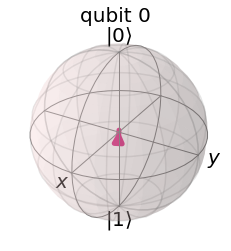

In [20]:
runs = 1024
out = {}

# We choose some random state outside the cycle
kirk, _ = random_state(qreg)

# Here we initialize a zero state vector density matrix
sv = qiskit.quantum_info.DensityMatrix([[0., 0.], [0., 0.]])

for i in range(runs):
    teleport = no_comm_teleport_state(kirk, qreg, cregx, cregz)

    # These commands execute a statevector computation
    # The partial trace selects only Bob'b qubit
    job = qiskit.execute(teleport, statevector)
    sv += qiskit.quantum_info.partial_trace(job.result().get_statevector(), [0, 1])

# Normalization
sv /= runs

plot_bloch_multivector(sv)